In [1]:
"""
Source: https://docs.ray.io/en/latest/ray-overview/getting-started.html 
"""

import os
from filelock import FileLock
from typing import Dict

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Normalize
from tqdm import tqdm

from ray import train
import ray.train
from ray.train import ScalingConfig, RunConfig
from ray.train.torch import TorchTrainer


/Users/mikhailrozhkov/dev/rnd/ray-dvc/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-01 14:44:22,967	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-01 14:44:23,186	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-01 14:44:23,236	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Define Model and helpers

In [2]:
def get_dataloaders(batch_size):
    # Transform to normalize the input images
    transform = transforms.Compose([ToTensor(), Normalize((0.5,), (0.5,))])

    with FileLock(os.path.expanduser("~/data.lock")):
        # Download training data from open datasets.
        training_data = datasets.FashionMNIST(
            root="~/data",
            train=True,
            download=True,
            transform=transform,
        )

        # Download test data from open datasets.
        test_data = datasets.FashionMNIST(
            root="~/data",
            train=False,
            download=True,
            transform=transform,
        )

    # Create data loaders.
    train_dataloader = DataLoader(training_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, test_dataloader


# Model Definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 10),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [3]:
# def train_func_per_worker(config: Dict):
#     lr = config["lr"]
#     epochs = config["epochs"]
#     batch_size = config["batch_size_per_worker"]

#     # Get dataloaders inside worker training function
#     train_dataloader, test_dataloader = get_dataloaders(batch_size=batch_size)

#     # [1] Prepare Dataloader for distributed training
#     # Shard the datasets among workers and move batches to the correct device
#     # =======================================================================
#     train_dataloader = ray.train.torch.prepare_data_loader(train_dataloader)
#     test_dataloader = ray.train.torch.prepare_data_loader(test_dataloader)

#     model = NeuralNetwork()

#     # [2] Prepare and wrap your model with DistributedDataParallel
#     # Move the model the correct GPU/CPU device
#     # ============================================================
#     model = ray.train.torch.prepare_model(model)

#     loss_fn = nn.CrossEntropyLoss()
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

#     # Model training loop
#     from dvclive import Live
#     from ray.train import get_context

#     train_context = get_context()
#     rank = train_context.get_local_rank()


#     with Live(dir='results/dvclive', dvcyaml=True, save_dvc_exp=False, resume=True) as live:

#         for epoch in range(epochs):
#             model.train()
#             for X, y in tqdm(train_dataloader, desc=f"Train Epoch {epoch}"):
#                 pred = model(X)
#                 loss = loss_fn(pred, y)

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             model.eval()
#             test_loss, num_correct, num_total = 0, 0, 0
#             with torch.no_grad():
#                 for X, y in tqdm(test_dataloader, desc=f"Test Epoch {epoch}"):
#                     pred = model(X)
#                     loss = loss_fn(pred, y)

#                     test_loss += loss.item()
#                     num_total += y.shape[0]
#                     num_correct += (pred.argmax(1) == y).sum().item()

#             test_loss /= len(test_dataloader)
#             accuracy = num_correct / num_total

#             # [3] Report metrics to Ray Train
#             # ===============================
#             ray.train.report(metrics={"loss": test_loss, "accuracy": accuracy})

#             # Log metrics with DVCLive 
#             if rank == 0:
#                 live.log_metric("loss", test_loss)
#                 live.log_metric("accuracy", accuracy)
#                 live.next_step()

In [4]:
def train_func_per_worker(config: Dict):
    lr = config["lr"]
    epochs = config["epochs"]
    batch_size = config["batch_size_per_worker"]

    # Get dataloaders inside worker training function
    train_dataloader, test_dataloader = get_dataloaders(batch_size=batch_size)

    # [1] Prepare Dataloader for distributed training
    # Shard the datasets among workers and move batches to the correct device
    # =======================================================================
    train_dataloader = ray.train.torch.prepare_data_loader(train_dataloader)
    test_dataloader = ray.train.torch.prepare_data_loader(test_dataloader)

    model = NeuralNetwork()

    # [2] Prepare and wrap your model with DistributedDataParallel
    # Move the model the correct GPU/CPU device
    # ============================================================
    model = ray.train.torch.prepare_model(model)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Model training loop
    from dvclive import Live
    from ray.train import get_context

    train_context = get_context()
    rank = train_context.get_local_rank()


    # with Live(dir='results/dvclive', dvcyaml=True, save_dvc_exp=False, resume=True) as live:

    for epoch in range(epochs):
        model.train()
        for X, y in tqdm(train_dataloader, desc=f"Train Epoch {epoch}"):
            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        test_loss, num_correct, num_total = 0, 0, 0
        with torch.no_grad():
            for X, y in tqdm(test_dataloader, desc=f"Test Epoch {epoch}"):
                pred = model(X)
                loss = loss_fn(pred, y)

                test_loss += loss.item()
                num_total += y.shape[0]
                num_correct += (pred.argmax(1) == y).sum().item()

        test_loss /= len(test_dataloader)
        accuracy = num_correct / num_total

        # [3] Report metrics to Ray Train
        # ===============================
        ray.train.report(metrics={"loss": test_loss, "accuracy": accuracy})

        # Log metrics with DVCLive 
        if rank == 0:
            print("loss", test_loss)
            print("accuracy", accuracy)
            print("---NEXT STEP---")

In [5]:
# Params 
num_workers=2
use_gpu=False


# def train_fashion_mnist(num_workers=2, use_gpu=False):
global_batch_size = 32

train_config = {
    "lr": 1e-3,
    "epochs": 5,
    "batch_size_per_worker": global_batch_size // num_workers,
}

# Configure computation resources
scaling_config = ScalingConfig(num_workers=num_workers, use_gpu=use_gpu)
# sync_config = ray.train.SyncConfig(sync_artifacts=True)



## Initialize a Ray TorchTrainer

In [7]:
# Initialize a Ray TorchTrainer
trainer = TorchTrainer(
    train_loop_per_worker=train_func_per_worker,
    train_loop_config=train_config,
    scaling_config=scaling_config,
    run_config=RunConfig(
        name="experiment_name",
        storage_path="~/dev/rnd/ray-dvc/results",
        # sync_config=sync_config
    )
)

# [4] Start Distributed Training
# Run `train_func_per_worker` on all workers
# =============================================
result: train.Result  = trainer.fit()
print(f"Training result: {result}")
print(f"result.filesystem: {result.filesystem}")
print(f"result.path: {result.path}")
print(f"result.metrics: {result.metrics}")
print(f"result.metrics_dataframe: {result.metrics_dataframe}")
print(f"result.config: {result.config}")

if result.checkpoint:
    print(f"result.checkpoint.path: {result.checkpoint.path}")

(TorchTrainer pid=45848) Starting distributed worker processes: ['45938 (127.0.0.1)', '45939 (127.0.0.1)']
(RayTrainWorker pid=45938) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=45938) Moving model to device: cpu
(RayTrainWorker pid=45938) Wrapping provided model in DistributedDataParallel.
Test Epoch 0:  35%|███▌      | 111/313 [00:00<00:00, 1108.94it/s]


(RayTrainWorker pid=45938) loss 0.5346211786634816
(RayTrainWorker pid=45938) accuracy 0.8018
(RayTrainWorker pid=45938) ---NEXT STEP---


Test Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]


(RayTrainWorker pid=45938) loss 0.4653822778762815
(RayTrainWorker pid=45938) accuracy 0.8322
(RayTrainWorker pid=45938) ---NEXT STEP---


Test Epoch 2:  34%|███▍      | 107/313 [00:00<00:00, 1068.46it/s]


(RayTrainWorker pid=45938) loss 0.426387041360854
(RayTrainWorker pid=45938) accuracy 0.8426
(RayTrainWorker pid=45938) ---NEXT STEP---


Train Epoch 3: 100%|██████████| 1875/1875 [00:09<00:00, 208.02it/s] [repeated 14x across cluster]


(RayTrainWorker pid=45938) loss 0.40899142906212577
(RayTrainWorker pid=45938) accuracy 0.85
(RayTrainWorker pid=45938) ---NEXT STEP---


Test Epoch 4:  34%|███▍      | 107/313 [00:00<00:00, 1064.16it/s]


(RayTrainWorker pid=45938) loss 0.38956472022792166
(RayTrainWorker pid=45938) accuracy 0.8586
(RayTrainWorker pid=45938) ---NEXT STEP---


Test Epoch 4: 100%|██████████| 313/313 [00:00<00:00, 1050.82it/s]
2023-11-01 14:47:39,803	INFO tune.py:1143 -- Total run time: 50.87 seconds (50.82 seconds for the tuning loop).


Training result: Result(
  metrics={'loss': 0.38956472022792166, 'accuracy': 0.8586},
  path='/Users/mikhailrozhkov/dev/rnd/ray-dvc/results/experiment_name/TorchTrainer_1ad48_00000_0_2023-11-01_14-46-48',
  filesystem='local',
  checkpoint=None
)
result.filesystem: <pyarrow._fs.LocalFileSystem object at 0x28b242170>
result.path: /Users/mikhailrozhkov/dev/rnd/ray-dvc/results/experiment_name/TorchTrainer_1ad48_00000_0_2023-11-01_14-46-48
result.metrics: {'loss': 0.38956472022792166, 'accuracy': 0.8586, 'timestamp': 1698846458, 'done': True, 'training_iteration': 5, 'trial_id': '1ad48_00000', 'date': '2023-11-01_14-47-38', 'time_this_iter_s': 9.277455806732178, 'time_total_s': 47.54027771949768, 'pid': 45848, 'hostname': 'mikhail.local', 'node_ip': '127.0.0.1', 'config': {'train_loop_config': {'lr': 0.001, 'epochs': 5, 'batch_size_per_worker': 16}}, 'time_since_restore': 47.54027771949768, 'iterations_since_restore': 5, 'checkpoint_dir_name': None, 'experiment_tag': '0'}
result.metrics_da

### Play with Ray Result API

In [13]:
result.metrics_dataframe

,loss,accuracy,timestamp,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/train_loop_config/lr,config/train_loop_config/epochs,config/train_loop_config/batch_size_per_worker
0,0.529073,0.8032,1698423491,False,1,6424d_00000,2023-10-27_18-18-11,11.160940,11.160940,86465,mikhail.local,127.0.0.1,11.160940,1,None,0.001,5,16
1,0.460328,0.8326,1698423500,False,2,6424d_00000,2023-10-27_18-18-20,9.235365,20.396305,86465,mikhail.local,127.0.0.1,20.396305,2,None,0.001,5,16
2,0.430507,0.8446,1698423509,False,3,6424d_00000,2023-10-27_18-18-29,8.996454,29.392759,86465,mikhail.local,127.0.0.1,29.392759,3,None,0.001,5,16
3,0.408980,0.8510,1698423518,False,4,6424d_00000,2023-10-27_18-18-38,9.061852,38.454612,86465,mikhail.local,127.0.0.1,38.454612,4,None,0.001,5,16
4,0.393715,0.8590,1698423527,False,5,6424d_00000,2023-10-27_18-18-47,9.020576,47.475188,86465,mikhail.local,127.0.0.1,47.475188,5,None,0.001,5,16


In [17]:
print(result._local_path)
print(result._remote_path)
print(result._storage_filesystem)

/Users/mikhailrozhkov/ray_results/experiment_name/TorchTrainer_6424d_00000_0_2023-10-27_18-17-57
/Users/mikhailrozhkov/dev/rnd/ray-dvc/results/experiment_name/TorchTrainer_6424d_00000_0_2023-10-27_18-17-57


In [37]:
result.filesystem.

In [38]:
report = {
    'config': result.config,
    'path': result.path,
    'metrics': result.metrics,
    'metrics_dataframe': result.metrics_dataframe.to_dict()
}

import json
with open('report.json', 'w') as f:
    json.dump(report, f)


In [39]:
with open('report.json', 'r') as f:
    train_report = json.load(f)

train_report

{'config': {'train_loop_config': {'lr': 0.001,
   'epochs': 5,
   'batch_size_per_worker': 16}},
 'path': '/Users/mikhailrozhkov/dev/rnd/ray-dvc/results/experiment_name/TorchTrainer_6424d_00000_0_2023-10-27_18-17-57',
 'metrics': {'loss': 0.39371506019700736,
  'accuracy': 0.859,
  'timestamp': 1698423527,
  'done': True,
  'training_iteration': 5,
  'trial_id': '6424d_00000',
  'date': '2023-10-27_18-18-47',
  'time_this_iter_s': 9.020576000213623,
  'time_total_s': 47.47518754005432,
  'pid': 86465,
  'hostname': 'mikhail.local',
  'node_ip': '127.0.0.1',
  'config': {'train_loop_config': {'lr': 0.001,
    'epochs': 5,
    'batch_size_per_worker': 16}},
  'time_since_restore': 47.47518754005432,
  'iterations_since_restore': 5,
  'checkpoint_dir_name': None,
  'experiment_tag': '0'},
 'metrics_dataframe': {'loss': {'0': 0.5290733393484031,
   '1': 0.4603284114061263,
   '2': 0.4305069556953713,
   '3': 0.40898048488524397,
   '4': 0.39371506019700736},
  'accuracy': {'0': 0.8032, '1'

In [71]:
from pathlib import Path

PROJECT_DIR = ".."

if train_report.get('path'):
    DVCLIVE_PATH_SOURCE = Path(train_report.get('path')) / 'results/dvclive'

    print(DVCLIVE_PATH_SOURCE)

DVCLIVE_DIR = Path(PROJECT_DIR) / "results/dvclive"

import shutil 

shutil.copytree(DVCLIVE_PATH_SOURCE, DVCLIVE_DIR.resolve(), dirs_exist_ok=True)

/Users/mikhailrozhkov/dev/rnd/ray-dvc/results/experiment_name/TorchTrainer_6424d_00000_0_2023-10-27_18-17-57/results/dvclive


PosixPath('/Users/mikhailrozhkov/dev/rnd/ray-dvc/results/dvclive')

In [68]:
DVCLIVE_DIR.resolve()

PosixPath('/Users/mikhailrozhkov/dev/rnd/ray-dvc/results/dvclive')

## Initialize a Ray TorchTrainer - Parameter Server

In [119]:
# Params 
num_workers=2
use_gpu=False


# def train_fashion_mnist(num_workers=2, use_gpu=False):
global_batch_size = 32

train_config = {
    "lr": 1e-3,
    "epochs": 5,
    "batch_size_per_worker": global_batch_size // num_workers,
}

# Configure computation resources
scaling_config = ScalingConfig(num_workers=num_workers, use_gpu=use_gpu)
# sync_config = ray.train.SyncConfig(sync_artifacts=True)



In [120]:
from typing import Union


class DVCLiveParameterServer(object):
    def __init__(self):
        self._step: Optional[int] = None
        self._metrics: Dict[str, Any] = {}
        self._params: Dict[str, Any] = {}

    def log_metric(
        self, 
        name: str,
        val: Union[int, float, str],
        step: Union[int, float, str],
    ):

        if name in self._metrics:
            metric = self._metrics[name]
        else:
            metric = {}

        metric.update({step: val})
        self._metrics.update({name: metric})
        return self._metrics[name]

    def get_metrics(self):
        return self._metrics

    def log_params(
        self, 
        name: str,
        val: Union[int, float, str],
        step: Union[int, float, str],
    ):

        if name in self._params:
            p = self._params[name]
        else:
            p = {}

        p.update({step: val})
        self._params.update({name: p})  
        return self._params[name] 

    def get_params(self):
        return self._params


@ray.remote
class DVCLiveParameterServerRemote(DVCLiveParameterServer):
    def __init___(self):
        super().__init__()


# Start parameter servers

ps = DVCLiveParameterServer()
ps

In [121]:
import random

for i in range(3): 
    ps.log_metric(name=f'metric_x', val=random.random(), step=i)
    ps.log_params(name=f'param_y', val=random.randint(5, 20), step=i)

print(ps.get_metrics(), ps.get_params())

{'metric_x': {0: 0.3785852544832995, 1: 0.27467545935282933, 2: 0.7351759621316337}} {'param_y': {0: 12, 1: 19, 2: 8}}


In [67]:
psr = DVCLiveParameterServerRemote.remote()
psr

for i in range(3): 
    psr.log_metric.remote(name=f'metric_x', val=random.random(), step=i)
    psr.log_metric.remote(name=f'metric_z', val=random.random(), step=i)
    psr.log_params.remote(name=f'param_y', val=random.randint(5, 20), step=i)

print(
    ray.get(psr.get_metrics.remote()), 
    ray.get(psr.get_params.remote()))

{'metric_x': {0: 0.5122420302855009, 1: 0.5666348283514934, 2: 0.7167602614146837}, 'metric_z': {0: 0.08097484432012814, 1: 0.246527935596355, 2: 0.4439109695968947}} {'param_y': {0: 10, 1: 12, 2: 16}}


In [72]:
metrics = ray.get(psr.get_metrics.remote())

metric = list(metrics.keys())[0]
len(metrics[metric])

3

In [110]:

def train_func_per_worker(config: Dict):
    lr = config["lr"]
    epochs = config["epochs"]
    batch_size = config["batch_size_per_worker"]

    # Get dataloaders inside worker training function
    train_dataloader, test_dataloader = get_dataloaders(batch_size=batch_size)

    # [1] Prepare Dataloader for distributed training
    # Shard the datasets among workers and move batches to the correct device
    # =======================================================================
    train_dataloader = ray.train.torch.prepare_data_loader(train_dataloader)
    test_dataloader = ray.train.torch.prepare_data_loader(test_dataloader)

    model = NeuralNetwork()

    # [2] Prepare and wrap your model with DistributedDataParallel
    # Move the model the correct GPU/CPU device
    # ============================================================
    model = ray.train.torch.prepare_model(model)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Model training loop
    from dvclive import Live
    from ray.train import get_context

    train_context = get_context()
    rank = train_context.get_local_rank()

    

    # with Live(dir='results/dvclive', dvcyaml=True, save_dvc_exp=False, resume=True) as live:

    for epoch in range(epochs):
        model.train()
        for X, y in tqdm(train_dataloader, desc=f"Train Epoch {epoch}"):
            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        test_loss, num_correct, num_total = 0, 0, 0
        with torch.no_grad():
            for X, y in tqdm(test_dataloader, desc=f"Test Epoch {epoch}"):
                pred = model(X)
                loss = loss_fn(pred, y)

                test_loss += loss.item()
                num_total += y.shape[0]
                num_correct += (pred.argmax(1) == y).sum().item()

        test_loss /= len(test_dataloader)
        accuracy = num_correct / num_total

        # [3] Report metrics to Ray Train
        # ===============================
        ray.train.report(metrics={"loss": test_loss, "accuracy": accuracy})

        # Log metrics with DVCLive 
        # live = config.get('dvc_parameter_server')
        live = psr
        
        if rank == 0:
            print("loss", test_loss)
            print("accuracy", accuracy)
            print("---NEXT STEP---")
            
            live.log_metric.remote(name="loss", val=test_loss, step=epoch)
            live.log_params.remote(name="accuracy", val=accuracy, step=epoch)
            print("Live object (psr): ", live)
            print("Logged Metrics (psr): ", live.get_metrics.remote())
            print("---METRICS LOGGED---")


In [111]:
psr = DVCLiveParameterServerRemote.remote()
print("PSR object: ", psr)

PSR object:  Actor(DVCLiveParameterServerRemote, c0208c70fe90d21426b0a97904000000)


In [118]:
psr.get_metrics.remote()

ObjectRef(11a8988bb9706a76c0208c70fe90d21426b0a9790400000001000000)

In [115]:
import time


# train_config.update({'dvc_parameter_server': psr})

# Initialize a Ray TorchTrainer
trainer = TorchTrainer(
    train_loop_per_worker=train_func_per_worker,
    train_loop_config=train_config,
    scaling_config=scaling_config,
    run_config=RunConfig(
        name="experiment_name",
        storage_path="~/dev/rnd/ray-dvc/results",
        # sync_config=sync_config
    )
)

# [4] Start Distributed Training
# Run `train_func_per_worker` on all workers
# =============================================

result: train.Result  = trainer.fit()

# @ray.remote 
# def run_train(trainer: TorchTrainer):
#     result: train.Result  = trainer.fit()
#     return result

# result = run_train.remote(trainer)

result: train.Result  = trainer.fit()
print(f"Training result: {result}")
print(f"result.filesystem: {result.filesystem}")
print(f"result.path: {result.path}")
print(f"result.metrics: {result.metrics}")
print(f"result.metrics_dataframe: {result.metrics_dataframe}")
print(f"result.config: {result.config}")

if result.checkpoint:
    print(f"result.checkpoint.path: {result.checkpoint.path}")

(run_train pid=42775) [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


(run_train pid=42775) 
(run_train pid=42775) View detailed results here: /Users/mikhailrozhkov/dev/rnd/ray-dvc/results/experiment_name
(run_train pid=42775) To visualize your results with TensorBoard, run: `tensorboard --logdir /Users/mikhailrozhkov/ray_results/experiment_name`


(TorchTrainer pid=84255) Starting distributed worker processes: ['84413 (127.0.0.1)', '84414 (127.0.0.1)']


(run_train pid=42775) 
(run_train pid=42775) Training started with configuration:
(run_train pid=42775) ╭────────────────────────────────────────────────────────────────╮
(run_train pid=42775) │ Training config                                                │
(run_train pid=42775) ├────────────────────────────────────────────────────────────────┤
(run_train pid=42775) │ train_loop_config/batch_size_per_worker                     16 │
(run_train pid=42775) │ train_loop_config/dvc_parameter_server    ...f6013cf404000000) │
(run_train pid=42775) │ train_loop_config/epochs                                     5 │
(run_train pid=42775) │ train_loop_config/lr                                     0.001 │
(run_train pid=42775) ╰────────────────────────────────────────────────────────────────╯


(RayTrainWorker pid=84413) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=84413) Moving model to device: cpu
(RayTrainWorker pid=84413) Wrapping provided model in DistributedDataParallel.
Train Epoch 0:   5%|▍         | 86/1875 [00:00<00:08, 215.11it/s]
(TorchTrainer pid=84344) Starting distributed worker processes: ['84436 (127.0.0.1)', '84437 (127.0.0.1)']
(RayTrainWorker pid=84436) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=84436) Moving model to device: cpu
(RayTrainWorker pid=84436) Wrapping provided model in DistributedDataParallel.
Test Epoch 0: 100%|██████████| 313/313 [00:00<00:00, 934.48it/s]


(RayTrainWorker pid=84413) loss 0.5271380199684789
(RayTrainWorker pid=84413) accuracy 0.803
(RayTrainWorker pid=84413) ---NEXT STEP---
(RayTrainWorker pid=84413) Live object (psr):  Actor(DVCLiveParameterServerRemote, c0208c70fe90d21426b0a97904000000)
(RayTrainWorker pid=84413) Logged Metrics (psr):  ObjectRef(b53177eecad4a339c0208c70fe90d21426b0a9790400000001000000)
(RayTrainWorker pid=84413) ---METRICS LOGGED---


Train Epoch 1:  12%|█▏        | 228/1875 [00:01<00:08, 201.40it/s] [repeated 5x across cluster]


(run_train pid=42775) 
(run_train pid=42775) Training finished iteration 1 at 2023-11-01 19:20:29. Total running time: 14s
(run_train pid=42775) ╭───────────────────────────────╮
(run_train pid=42775) │ Training result               │
(run_train pid=42775) ├───────────────────────────────┤
(run_train pid=42775) │ checkpoint_dir_name           │
(run_train pid=42775) │ time_this_iter_s      11.8505 │
(run_train pid=42775) │ time_total_s          11.8505 │
(run_train pid=42775) │ training_iteration          1 │
(run_train pid=42775) │ accuracy               0.8024 │
(run_train pid=42775) │ loss                  0.52852 │
(run_train pid=42775) ╰───────────────────────────────╯


Test Epoch 1: 100%|██████████| 313/313 [00:00<00:00, 822.48it/s]


(RayTrainWorker pid=84413) loss 0.4612438741345375 [repeated 2x across cluster]
(RayTrainWorker pid=84413) accuracy 0.8336 [repeated 2x across cluster]
(RayTrainWorker pid=84413) ---NEXT STEP--- [repeated 2x across cluster]
(RayTrainWorker pid=84413) Live object (psr):  Actor(DVCLiveParameterServerRemote, c0208c70fe90d21426b0a97904000000) [repeated 2x across cluster]
(RayTrainWorker pid=84413) Logged Metrics (psr):  ObjectRef(0403899d1b6da206c0208c70fe90d21426b0a9790400000001000000) [repeated 2x across cluster]
(RayTrainWorker pid=84413) ---METRICS LOGGED--- [repeated 2x across cluster]


Train Epoch 2:   5%|▌         | 98/1875 [00:00<00:09, 196.24it/s] [repeated 4x across cluster]


(run_train pid=42775) 
(run_train pid=42775) Training finished iteration 2 at 2023-11-01 19:20:39. Total running time: 24s
(run_train pid=42775) ╭───────────────────────────────╮
(run_train pid=42775) │ Training result               │
(run_train pid=42775) ├───────────────────────────────┤
(run_train pid=42775) │ checkpoint_dir_name           │
(run_train pid=42775) │ time_this_iter_s      10.0314 │
(run_train pid=42775) │ time_total_s          21.8819 │
(run_train pid=42775) │ training_iteration          2 │
(run_train pid=42775) │ accuracy               0.8272 │
(run_train pid=42775) │ loss                  0.46816 │
(run_train pid=42775) ╰───────────────────────────────╯


Test Epoch 2: 100%|██████████| 313/313 [00:00<00:00, 899.07it/s]


(RayTrainWorker pid=84413) loss 0.4305400553400429 [repeated 2x across cluster]
(RayTrainWorker pid=84413) accuracy 0.8432 [repeated 2x across cluster]
(RayTrainWorker pid=84413) ---NEXT STEP--- [repeated 2x across cluster]
(RayTrainWorker pid=84413) Live object (psr):  Actor(DVCLiveParameterServerRemote, c0208c70fe90d21426b0a97904000000) [repeated 2x across cluster]
(RayTrainWorker pid=84413) Logged Metrics (psr):  ObjectRef(24fc8e5cfb5480f0c0208c70fe90d21426b0a9790400000001000000) [repeated 2x across cluster]
(RayTrainWorker pid=84413) ---METRICS LOGGED--- [repeated 2x across cluster]


Test Epoch 2:  27%|██▋       | 85/313 [00:00<00:00, 849.13it/s]


(run_train pid=42775) 
(run_train pid=42775) Training finished iteration 3 at 2023-11-01 19:20:49. Total running time: 34s
(run_train pid=42775) ╭───────────────────────────────╮
(run_train pid=42775) │ Training result               │
(run_train pid=42775) ├───────────────────────────────┤
(run_train pid=42775) │ checkpoint_dir_name           │
(run_train pid=42775) │ time_this_iter_s       10.357 │
(run_train pid=42775) │ time_total_s          32.2389 │
(run_train pid=42775) │ training_iteration          3 │
(run_train pid=42775) │ accuracy               0.8436 │
(run_train pid=42775) │ loss                  0.43038 │
(run_train pid=42775) ╰───────────────────────────────╯


Test Epoch 3: 100%|██████████| 313/313 [00:00<00:00, 894.67it/s]


(RayTrainWorker pid=84413) loss 0.40948573166665175 [repeated 2x across cluster]
(RayTrainWorker pid=84413) accuracy 0.8518 [repeated 2x across cluster]
(RayTrainWorker pid=84413) ---NEXT STEP--- [repeated 2x across cluster]
(RayTrainWorker pid=84413) Live object (psr):  Actor(DVCLiveParameterServerRemote, c0208c70fe90d21426b0a97904000000) [repeated 2x across cluster]
(RayTrainWorker pid=84413) Logged Metrics (psr):  ObjectRef(96b03d7c0b6b6b98c0208c70fe90d21426b0a9790400000001000000) [repeated 2x across cluster]
(RayTrainWorker pid=84413) ---METRICS LOGGED--- [repeated 2x across cluster]


Train Epoch 3:  76%|███████▌  | 1426/1875 [00:07<00:02, 202.36it/s] [repeated 3x across cluster]


(run_train pid=42775) 
(run_train pid=42775) Training finished iteration 4 at 2023-11-01 19:20:59. Total running time: 44s
(run_train pid=42775) ╭───────────────────────────────╮
(run_train pid=42775) │ Training result               │
(run_train pid=42775) ├───────────────────────────────┤
(run_train pid=42775) │ checkpoint_dir_name           │
(run_train pid=42775) │ time_this_iter_s      10.2984 │
(run_train pid=42775) │ time_total_s          42.5373 │
(run_train pid=42775) │ training_iteration          4 │
(run_train pid=42775) │ accuracy               0.8524 │
(run_train pid=42775) │ loss                  0.40767 │
(run_train pid=42775) ╰───────────────────────────────╯


Test Epoch 4: 100%|██████████| 313/313 [00:00<00:00, 879.29it/s]


(RayTrainWorker pid=84413) loss 0.3948033210470344 [repeated 2x across cluster]
(RayTrainWorker pid=84413) accuracy 0.8576 [repeated 2x across cluster]
(RayTrainWorker pid=84413) ---NEXT STEP--- [repeated 2x across cluster]
(RayTrainWorker pid=84413) Live object (psr):  Actor(DVCLiveParameterServerRemote, c0208c70fe90d21426b0a97904000000) [repeated 2x across cluster]
(RayTrainWorker pid=84413) Logged Metrics (psr):  ObjectRef(6dea81e33e957a2fc0208c70fe90d21426b0a9790400000001000000) [repeated 2x across cluster]
(RayTrainWorker pid=84413) ---METRICS LOGGED--- [repeated 2x across cluster]


2023-11-01 19:21:08,618	INFO tune.py:1143 -- Total run time: 55.12 seconds (55.08 seconds for the tuning loop).


Training result: Result(
  metrics={'loss': 0.3948033210470344, 'accuracy': 0.8576},
  path='/Users/mikhailrozhkov/dev/rnd/ray-dvc/results/experiment_name/TorchTrainer_4cb62_00000_0_2023-11-01_19-20-13',
  filesystem='local',
  checkpoint=None
)
result.filesystem: <pyarrow._fs.LocalFileSystem object at 0x359821ef0>
result.path: /Users/mikhailrozhkov/dev/rnd/ray-dvc/results/experiment_name/TorchTrainer_4cb62_00000_0_2023-11-01_19-20-13
result.metrics: {'loss': 0.3948033210470344, 'accuracy': 0.8576, 'timestamp': 1698862867, 'done': True, 'training_iteration': 5, 'trial_id': '4cb62_00000', 'date': '2023-11-01_19-21-07', 'time_this_iter_s': 10.34861421585083, 'time_total_s': 51.55340003967285, 'pid': 84255, 'hostname': 'mikhail.local', 'node_ip': '127.0.0.1', 'config': {'train_loop_config': {'lr': 0.001, 'epochs': 5, 'batch_size_per_worker': 16, 'dvc_parameter_server': Actor(DVCLiveParameterServerRemote, 86853ec01a94505cf6013cf404000000)}}, 'time_since_restore': 51.55340003967285, 'iterat

Train Epoch 4:  89%|████████▉ | 1672/1875 [00:08<00:01, 202.52it/s]


In [116]:
# Inspect the parameters at regular intervals until we've 
# reached the end (i.e., each parameter equals 200)
while True:
    time.sleep(5)
    
    metrics = ray.get(psr.get_metrics.remote())
    print(metrics)

    if len(metrics.keys()) == 0: 
        continue
    
    else: 
        metric = list(metrics.keys())[0]
        steps = len(metrics[metric])
        if steps >= train_config["epochs"]:
            break



Test Epoch 4:  35%|███▍      | 109/313 [00:00<00:00, 1085.02it/s]


(run_train pid=42775) 
(run_train pid=42775) Training finished iteration 5 at 2023-11-01 19:21:10. Total running time: 55s
(run_train pid=42775) ╭───────────────────────────────╮
(run_train pid=42775) │ Training result               │
(run_train pid=42775) ├───────────────────────────────┤
(run_train pid=42775) │ checkpoint_dir_name           │
(run_train pid=42775) │ time_this_iter_s      10.1747 │
(run_train pid=42775) │ time_total_s           52.712 │
(run_train pid=42775) │ training_iteration          5 │
(run_train pid=42775) │ accuracy               0.8578 │
(run_train pid=42775) │ loss                  0.39158 │
(run_train pid=42775) ╰───────────────────────────────╯
(RayTrainWorker pid=84436) loss 0.3915770130511671
(RayTrainWorker pid=84436) accuracy 0.8578
(RayTrainWorker pid=84436) ---NEXT STEP---
(RayTrainWorker pid=84436) Live object (psr):  Actor(DVCLiveParameterServerRemote, c0208c70fe90d21426b0a97904000000)
(RayTrainWorker pid=84436) Logged Metrics (psr):  ObjectRef(8d2

Test Epoch 4: 100%|██████████| 313/313 [00:00<00:00, 1065.63it/s]


(run_train pid=42775) 
(run_train pid=42775) Training completed after 5 iterations at 2023-11-01 19:21:11. Total running time: 56s
(run_train pid=42775) 
{'loss': {0: 0.5285213752307545, 1: 0.46816452414083026, 2: 0.43038335688912066, 3: 0.4076656031365783, 4: 0.3915770130511671}}


# Tune 

## Tune Example 
https://docs.ray.io/en/latest/tune/examples/tune_analyze_results.html 

In [124]:

import os

from ray import train, tune
from ray.tune.examples.mnist_pytorch import train_mnist
from ray.tune import ResultGrid

storage_path = "/tmp/ray_results"
exp_name = "tune_analyzing_results"

tuner = tune.Tuner(
    train_mnist,
    param_space={
        "lr": tune.loguniform(0.001, 0.1),
        "momentum": tune.grid_search([0.8, 0.9, 0.99]),
        "should_checkpoint": True,
    },
    run_config=train.RunConfig(
        name=exp_name,
        stop={"training_iteration": 100},
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="mean_accuracy",
            num_to_keep=5,
        ),
        storage_path=storage_path,
    ),
    tune_config=tune.TuneConfig(mode="max", metric="mean_accuracy", num_samples=3),
)
result_grid: ResultGrid = tuner.fit()

(train_mnist pid=23850) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(train_mnist pid=23850) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to /Users/mikhailrozhkov/data/MNIST/raw/train-images-idx3-ubyte.gz


100%|██████████| 9912422/9912422 [00:09<00:00, 1097363.50it/s]


(train_mnist pid=23850) Extracting /Users/mikhailrozhkov/data/MNIST/raw/train-images-idx3-ubyte.gz to /Users/mikhailrozhkov/data/MNIST/raw
(train_mnist pid=23850) 
(train_mnist pid=23850) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(train_mnist pid=23850) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to /Users/mikhailrozhkov/data/MNIST/raw/train-labels-idx1-ubyte.gz
(train_mnist pid=23850) Extracting /Users/mikhailrozhkov/data/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/mikhailrozhkov/data/MNIST/raw
(train_mnist pid=23850) 
(train_mnist pid=23850) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(train_mnist pid=23850) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to /Users/mikhailrozhkov/data/MNIST/raw/t10k-images-idx3-ubyte.gz


100%|██████████| 1648877/1648877 [00:01<00:00, 1121396.73it/s]


(train_mnist pid=23850) Extracting /Users/mikhailrozhkov/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/mikhailrozhkov/data/MNIST/raw
(train_mnist pid=23850) 
(train_mnist pid=23850) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(train_mnist pid=23850) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to /Users/mikhailrozhkov/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(train_mnist pid=23850) Extracting /Users/mikhailrozhkov/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/mikhailrozhkov/data/MNIST/raw
(train_mnist pid=23850) 


100%|██████████| 4542/4542 [00:00<00:00, 2953112.50it/s]
(train_mnist pid=23855) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_83356_00005_5_lr=0.0324,momentum=0.9900_2023-11-02_13-29-48/checkpoint_000000)
2023-11-02 13:30:03,997	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has checkpointed more than `num_to_keep` times since last sync or if 300 seconds have passed since last sync. If you have set `num_to_keep` in your `CheckpointConfig`, consider increasing the checkpoint frequency or keeping more checkpoints. You can supress this warning by changing the `TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S` environment variable.
2023-11-02 13:30:04,317	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync w

In [190]:
result_grid.get_dataframe()

,mean_accuracy,timestamp,should_checkpoint,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/lr,config/momentum,config/should_checkpoint,logdir
0,0.965625,1698933312,True,True,100,6b604_00000,2023-11-02_14-55-12,0.058764,6.481322,37127,mikhail.local,127.0.0.1,6.481322,100,checkpoint_000099,0.076083,0.8,True,6b604_00000
1,0.940625,1698933312,True,True,100,6b604_00001,2023-11-02_14-55-12,0.059970,6.438105,37128,mikhail.local,127.0.0.1,6.438105,100,checkpoint_000099,0.003973,0.9,True,6b604_00001
2,0.900000,1698933311,True,True,100,6b604_00002,2023-11-02_14-55-11,0.060060,6.276443,37129,mikhail.local,127.0.0.1,6.276443,100,checkpoint_000099,0.001603,0.8,True,6b604_00002
3,0.940625,1698933312,True,True,100,6b604_00003,2023-11-02_14-55-12,0.064846,6.403936,37130,mikhail.local,127.0.0.1,6.403936,100,checkpoint_000099,0.007156,0.9,True,6b604_00003
4,0.943750,1698933311,True,True,100,6b604_00004,2023-11-02_14-55-11,0.059522,6.349655,37131,mikhail.local,127.0.0.1,6.349655,100,checkpoint_000099,0.009593,0.8,True,6b604_00004
5,0.903125,1698933312,True,True,100,6b604_00005,2023-11-02_14-55-12,0.066313,6.369621,37132,mikhail.local,127.0.0.1,6.369621,100,checkpoint_000099,0.003507,0.9,True,6b604_00005


In [126]:
!ls /tmp/ray_results/tune_analyzing_results/train_mnist_83356_00000_0_lr=0.0748,momentum=0.8000_2023-11-02_13-29-48

checkpoint_000041
checkpoint_000050
checkpoint_000063
checkpoint_000083
checkpoint_000094
checkpoint_000099
events.out.tfevents.1698928191.mikhail.local
params.json
params.pkl
progress.csv
result.json


## Loading experiment results from an directory

In [191]:
# https://docs.ray.io/en/latest/tune/examples/tune_analyze_results.html#loading-experiment-results-from-an-directory 

experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable=train_mnist)
result_grid = restored_tuner.get_results()

Loading results from /tmp/ray_results/tune_analyzing_results...


In [192]:
result_grid

ResultGrid<[
  Result(
    metrics={'mean_accuracy': 0.965625},
    path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00000_0_lr=0.0761,momentum=0.8000_2023-11-02_14-55-02',
    filesystem='local',
    checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00000_0_lr=0.0761,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000099)
  ),
  Result(
    metrics={'mean_accuracy': 0.9},
    path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00002_2_lr=0.0016,momentum=0.8000_2023-11-02_14-55-02',
    filesystem='local',
    checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00002_2_lr=0.0016,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000099)
  ),
  Result(
    metrics={'mean_accuracy': 0.940625},
    path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00001_1_lr=0.0040,momentum=0.9000_2023-11-02_14-55-02',
    filesystem='local',
    checkpoint=Checkpoint

### Experiment-level Analysis: Working with ResultGrid

In [193]:
# Check if there have been errors
if result_grid.errors:
    print("One of the trials failed!")
else:
    print("No errors!")

No errors!


In [194]:
num_results = len(result_grid)
print("Number of results:", num_results)

Number of results: 6


In [195]:
result_grid.get_dataframe()


,mean_accuracy,timestamp,should_checkpoint,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/lr,config/momentum,config/should_checkpoint,logdir
0,0.965625,1698933312,True,True,100,6b604_00000,2023-11-02_14-55-12,0.058764,6.481322,37127,mikhail.local,127.0.0.1,6.481322,100,checkpoint_000099,0.076083,0.8,True,6b604_00000
1,0.900000,1698933311,True,True,100,6b604_00002,2023-11-02_14-55-11,0.060060,6.276443,37129,mikhail.local,127.0.0.1,6.276443,100,checkpoint_000099,0.001603,0.8,True,6b604_00002
2,0.940625,1698933312,True,True,100,6b604_00001,2023-11-02_14-55-12,0.059970,6.438105,37128,mikhail.local,127.0.0.1,6.438105,100,checkpoint_000099,0.003973,0.9,True,6b604_00001
3,0.943750,1698933311,True,True,100,6b604_00004,2023-11-02_14-55-11,0.059522,6.349655,37131,mikhail.local,127.0.0.1,6.349655,100,checkpoint_000099,0.009593,0.8,True,6b604_00004
4,0.903125,1698933312,True,True,100,6b604_00005,2023-11-02_14-55-12,0.066313,6.369621,37132,mikhail.local,127.0.0.1,6.369621,100,checkpoint_000099,0.003507,0.9,True,6b604_00005
5,0.940625,1698933312,True,True,100,6b604_00003,2023-11-02_14-55-12,0.064846,6.403936,37130,mikhail.local,127.0.0.1,6.403936,100,checkpoint_000099,0.007156,0.9,True,6b604_00003


In [196]:
# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a mean accuracy metric of:",
        result.metrics["mean_accuracy"]
    )

Trial #0 finished successfully with a mean accuracy metric of: 0.965625
Trial #1 finished successfully with a mean accuracy metric of: 0.9
Trial #2 finished successfully with a mean accuracy metric of: 0.940625
Trial #3 finished successfully with a mean accuracy metric of: 0.94375
Trial #4 finished successfully with a mean accuracy metric of: 0.903125
Trial #5 finished successfully with a mean accuracy metric of: 0.940625


In [197]:
results_df = result_grid.get_dataframe()
results_df[["training_iteration", "mean_accuracy"]]

,training_iteration,mean_accuracy
0,100,0.965625
1,100,0.900000
2,100,0.940625
3,100,0.943750
4,100,0.903125
5,100,0.940625


In [217]:
print("Best trial: \n", results_df.iloc[results_df['mean_accuracy'].idxmax()])

Best trial: 
 mean_accuracy                          0.965625
timestamp                            1698933312
should_checkpoint                          True
done                                       True
training_iteration                          100
trial_id                            6b604_00000
date                        2023-11-02_14-55-12
time_this_iter_s                       0.058764
time_total_s                           6.481322
pid                                       37127
hostname                          mikhail.local
node_ip                               127.0.0.1
time_since_restore                     6.481322
iterations_since_restore                    100
checkpoint_dir_name           checkpoint_000099
config/lr                              0.076083
config/momentum                             0.8
config/should_checkpoint                   True
logdir                              6b604_00000
Name: 0, dtype: object


In [220]:
best_result_df = result_grid.get_dataframe(
    filter_metric="mean_accuracy", filter_mode="max"
)
best_result_df[["training_iteration", "mean_accuracy"]]

,training_iteration,mean_accuracy
0,78,0.978125
1,68,0.921875
2,55,0.962500
3,90,0.956250
4,94,0.925000
5,83,0.965625


### Trial-level Analysis: Working with an individual Result 

In [256]:
from ray.train import Result

# Get the result with the maximum test set `mean_accuracy`
best_result: Result = result_grid.get_best_result()

# Get the result with the minimum `mean_accuracy`
worst_performing_result: Result = result_grid.get_best_result(
    metric="mean_accuracy", mode="min"
)

In [257]:
best_result

Result(
  metrics={'mean_accuracy': 0.965625},
  path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00000_0_lr=0.0761,momentum=0.8000_2023-11-02_14-55-02',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00000_0_lr=0.0761,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000099)
)

In [258]:
worst_performing_result

Result(
  metrics={'mean_accuracy': 0.9},
  path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00002_2_lr=0.0016,momentum=0.8000_2023-11-02_14-55-02',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00002_2_lr=0.0016,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000099)
)

In [224]:
best_result.config

{'lr': 0.07608281902183818, 'momentum': 0.8, 'should_checkpoint': True}

In [225]:
best_result.metrics

{'mean_accuracy': 0.965625,
 'timestamp': 1698933312,
 'should_checkpoint': True,
 'done': True,
 'training_iteration': 100,
 'trial_id': '6b604_00000',
 'date': '2023-11-02_14-55-12',
 'time_this_iter_s': 0.058763980865478516,
 'time_total_s': 6.481321811676025,
 'pid': 37127,
 'hostname': 'mikhail.local',
 'node_ip': '127.0.0.1',
 'config': {'lr': 0.07608281902183818,
  'momentum': 0.8,
  'should_checkpoint': True},
 'time_since_restore': 6.481321811676025,
 'iterations_since_restore': 100,
 'checkpoint_dir_name': 'checkpoint_000099',
 'experiment_tag': '0_lr=0.0761,momentum=0.8000'}

### Plotting metrics

In [228]:
# !pip install matplotlib

     |████████████████████████████████| 7.5 MB 879 kB/s eta 0:00:01
     |████████████████████████████████| 232 kB 804 kB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 759 kB/s eta 0:00:01
     |████████████████████████████████| 66 kB 971 kB/s eta 0:00:01
You should consider upgrading via the '/Users/mikhailrozhkov/dev/rnd/ray-dvc/.venv/bin/python3 -m pip install --upgrade pip' command.


In [229]:
import matplotlib.pyplot as plt

<Axes: xlabel='training_iteration'>

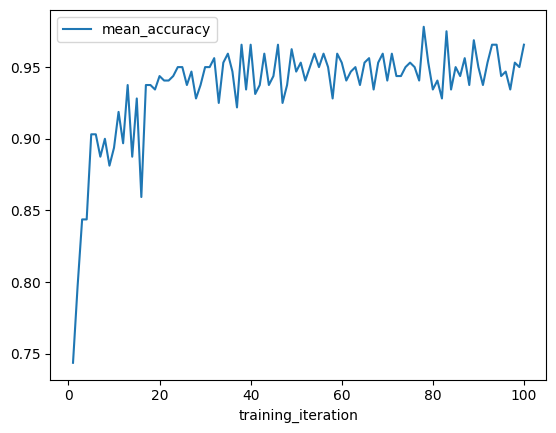

In [230]:
best_result.metrics_dataframe.plot("training_iteration", "mean_accuracy")

In [233]:
best_result.metrics_dataframe.loc[:, ["training_iteration", "mean_accuracy"]]

,training_iteration,mean_accuracy
0,1,0.743750
1,2,0.796875
2,3,0.843750
3,4,0.843750
4,5,0.903125
...,...,...
95,96,0.946875
96,97,0.934375
97,98,0.953125
98,99,0.950000


Text(0, 0.5, 'Mean Test Accuracy')

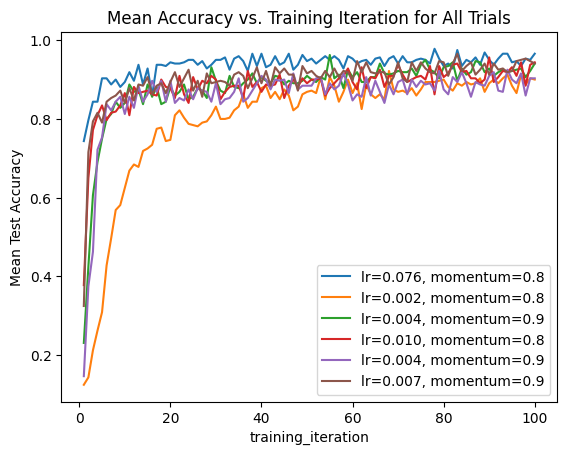

In [234]:
ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.3f}, momentum={result.config['momentum']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "mean_accuracy", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "mean_accuracy", ax=ax, label=label)
ax.set_title("Mean Accuracy vs. Training Iteration for All Trials")
ax.set_ylabel("Mean Test Accuracy")

### Accessing checkpoints and loading for test inference

In [284]:
import torch

from ray.tune.examples.mnist_pytorch import ConvNet, get_data_loaders

model = ConvNet()
with best_result.checkpoint.as_directory() as checkpoint_dir:
    # The model state dict was saved under `model.pt` by the training function
    # imported from `ray.tune.examples.mnist_pytorch`
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "model.pt")))

model_bad = ConvNet()
with worst_performing_result.checkpoint.as_directory() as checkpoint_dir:
    model_bad.load_state_dict(torch.load(os.path.join(checkpoint_dir, "model.pt")))

In [254]:
worst_performing_result.checkpoint

Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00002_2_lr=0.0016,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000099)

In [255]:
best_result.checkpoint

Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00000_0_lr=0.0761,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000099)

In [293]:
import matplotlib.pyplot as plt

_, test_loader = get_data_loaders()
test_img = next(iter(test_loader))[0][0]

Predicted Class = 7


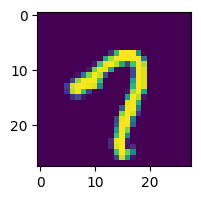

In [294]:
predicted_class = torch.argmax(model(test_img)).item()
print("Predicted Class =", predicted_class)

# Need to reshape to (batch_size, channels, width, height)
test_img_out = test_img.numpy().reshape((1, 1, 28, 28))
plt.figure(figsize=(2, 2))
plt.imshow(test_img_out.reshape((28, 28)))

Predicted Class = 9


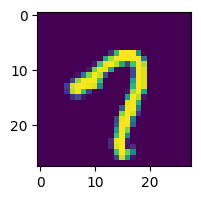

In [295]:
predicted_class = torch.argmax(model_bad(test_img)).item()
print("Predicted Class =", predicted_class)

# Need to reshape to (batch_size, channels, width, height)
test_img_out = test_img.numpy().reshape((1, 1, 28, 28))
plt.figure(figsize=(2, 2))
plt.imshow(test_img_out.reshape((28, 28)))

In [274]:
test_img

array([[[[-0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296],
         [-0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296],
         [-0.42421296, -0.42421296, -0.42421296, -0.42421296,
          -0.42421296, -0.42421296, -0.42421296, -0.42421296,
      

## Custom Reporter 

In [180]:
from ray import air
from ray.tune import ProgressReporter

from typing import Dict, List

import json
import os

from ray.tune.logger import LoggerCallback, JsonLoggerCallback

class CustomReporter(ProgressReporter):

    def should_report(self, trials, done=False):
        return True

    def report(self, trials, *sys_info):
        print("---")
        print("CUSTOM REPORTER")
        print(*sys_info)
        print("TRIAL: ", trials[0])
        s = "\n".join([str(trial) for trial in trials])

        with open("custom_reporter_log.txt", "a") as log:
            log.write(s)

class CustomLoggerCallback(LoggerCallback):
    """Custom logger interface"""

    def __init__(self, filename: str = "log.txt"):
        self._trial_files = {}
        self._filename = filename

    def log_trial_start(self, trial: "Trial"):
        # trial_logfile = os.path.join(trial.logdir, self._filename)
        trial_logfile = self._filename
        self._trial_files[trial] = open(trial_logfile, "at")

    def log_trial_result(self, iteration: int, trial: "Trial", result: Dict):
        if trial in self._trial_files:
            self._trial_files[trial].write(json.dumps(result))

    def on_trial_complete(self, iteration: int, trials: List["Trial"],
                          trial: "Trial", **info):
        if trial in self._trial_files:
            self._trial_files[trial].close()
            del self._trial_files[trial]

    # def on_step_end(self, iteration: int, trials: List["Trial"]):
    #     if trial in self._trial_files:
    #         self._trial_files[trial].write(json.dumps(result))
            
    #         self._filename.write(json.dumps(trial))


        

In [184]:
import logging

# First, get the handle for the logger you want to modify
ray_tune_logger = logging.getLogger("ray.tune")

# Other loggers can be modified similarly.
# Here's how to add an aditional file handler for Ray Tune:
ray_tune_logger.addHandler(logging.FileHandler("extra_ray_tune_log.log"))

tuner = tune.Tuner(
    train_mnist,
    param_space={
        "lr": tune.loguniform(0.001, 0.1),
        "momentum": tune.grid_search([0.8, 0.9]),
        "should_checkpoint": True,
    },
    run_config=train.RunConfig(
        name=exp_name,
        stop={"training_iteration": 100},
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="mean_accuracy",
            num_to_keep=5,
        ),
        storage_path=storage_path,
        # progress_reporter=CustomReporter(),
        # callbacks=[CustomLoggerCallback("log_test.txt")]
        # callbacks=[JsonLoggerCallback]
    ),
    tune_config=tune.TuneConfig(mode="max", metric="mean_accuracy", num_samples=3),
)
tuner

In [186]:
result_grid: ResultGrid = tuner.fit()
result_grid

(train_mnist pid=37131) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00004_4_lr=0.0096,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000000)
(train_mnist pid=37131) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00004_4_lr=0.0096,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000001)
(train_mnist pid=37131) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00004_4_lr=0.0096,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000002)
(train_mnist pid=37131) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00004_4_lr=0.0096,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000003)
2023-11-02 14:55:05,446	WARNING experiment_state.py:371 -- Experiment checkpoint syncing has been tr

ResultGrid<[
  Result(
    metrics={'mean_accuracy': 0.965625},
    path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00000_0_lr=0.0761,momentum=0.8000_2023-11-02_14-55-02',
    filesystem='local',
    checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00000_0_lr=0.0761,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000099)
  ),
  Result(
    metrics={'mean_accuracy': 0.940625},
    path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00001_1_lr=0.0040,momentum=0.9000_2023-11-02_14-55-02',
    filesystem='local',
    checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00001_1_lr=0.0040,momentum=0.9000_2023-11-02_14-55-02/checkpoint_000099)
  ),
  Result(
    metrics={'mean_accuracy': 0.9},
    path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00002_2_lr=0.0016,momentum=0.8000_2023-11-02_14-55-02',
    filesystem='local',
    checkpoint=Checkpoint

In [188]:
tuner.get_results()

ResultGrid<[
  Result(
    metrics={'mean_accuracy': 0.965625},
    path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00000_0_lr=0.0761,momentum=0.8000_2023-11-02_14-55-02',
    filesystem='local',
    checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00000_0_lr=0.0761,momentum=0.8000_2023-11-02_14-55-02/checkpoint_000099)
  ),
  Result(
    metrics={'mean_accuracy': 0.940625},
    path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00001_1_lr=0.0040,momentum=0.9000_2023-11-02_14-55-02',
    filesystem='local',
    checkpoint=Checkpoint(filesystem=local, path=/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00001_1_lr=0.0040,momentum=0.9000_2023-11-02_14-55-02/checkpoint_000099)
  ),
  Result(
    metrics={'mean_accuracy': 0.9},
    path='/tmp/ray_results/tune_analyzing_results/train_mnist_6b604_00002_2_lr=0.0016,momentum=0.8000_2023-11-02_14-55-02',
    filesystem='local',
    checkpoint=Checkpoint

In [156]:
!ls /tmp/ray_results/tune_analyzing_results/train_mnist_6cf8a_00005_5_lr=0.0077,momentum=0.9000_2023-11-02_14-04-58



checkpoint_000026
checkpoint_000076
checkpoint_000080
checkpoint_000091
checkpoint_000099
events.out.tfevents.1698930301.mikhail.local
params.json
params.pkl
progress.csv
result.json


In [179]:
result_grid.get_dataframe()

,mean_accuracy,timestamp,should_checkpoint,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,checkpoint_dir_name,config/lr,config/momentum,config/should_checkpoint,logdir
0,0.956250,1698931733,True,True,100,beba5_00000,2023-11-02_14-28-53,0.058855,6.530602,33842,mikhail.local,127.0.0.1,6.530602,100,checkpoint_000099,0.033999,0.8,True,beba5_00000
1,0.937500,1698931733,True,True,100,beba5_00001,2023-11-02_14-28-53,0.060833,6.199049,33843,mikhail.local,127.0.0.1,6.199049,100,checkpoint_000099,0.036616,0.9,True,beba5_00001
2,0.906250,1698931733,True,True,100,beba5_00002,2023-11-02_14-28-53,0.062563,6.376014,33844,mikhail.local,127.0.0.1,6.376014,100,checkpoint_000099,0.003810,0.8,True,beba5_00002
3,0.950000,1698931733,True,True,100,beba5_00003,2023-11-02_14-28-53,0.058707,6.216974,33845,mikhail.local,127.0.0.1,6.216974,100,checkpoint_000099,0.012182,0.9,True,beba5_00003
4,0.834375,1698931733,True,True,100,beba5_00004,2023-11-02_14-28-53,0.058378,6.492457,33846,mikhail.local,127.0.0.1,6.492457,100,checkpoint_000099,0.001316,0.8,True,beba5_00004
5,0.943750,1698931733,True,True,100,beba5_00005,2023-11-02_14-28-53,0.061848,6.417250,33847,mikhail.local,127.0.0.1,6.417250,100,checkpoint_000099,0.011256,0.9,True,beba5_00005
